IMPORTING REQUIRED MODULES

In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
#from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam

INSTALLATION , LOGGING IN , INITIALIZATION AND CONFIGURATION OF WANDB

In [40]:
dataset, dataset_info =tfds.load("malaria",with_info=True,
                                 as_supervised=True,
                                 split=['train[:80%]','train[80%:90%]','train[90%:]'],
                                 shuffle_files = True
                                 )


In [41]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [42]:
train_ds = dataset[0]
val_ds = dataset[1]
test_ds = dataset[2]

In [43]:
for data in dataset[0].take(1):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [51]:
#def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
 # DATASET_SIZE = len(dataset)

  #train_ds = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  #val_test_ds = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  #val_ds = val_test_ds.take(int(VAL_RATIO*DATASET_SIZE))

  #test_ds = val_test_ds.skip(int(TEST_RATIO*DATASET_SIZE))
  #return train_ds, val_ds, test_ds

In [54]:
#TRAIN_RATIO = 0.8
#VAL_RATIO = 0.1
#TEST_RATIO = 0.1

#train_ds, val_ds, test_ds = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )


In [44]:
train_ds


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [7]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

22046
2756
2756


In [8]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

In [9]:
def get_label_str(label):
  if label == 0:
    return " Parasitized"
  else:
    return "Uninfected"

1
1
0
0
1
0
1
0
1
1
1
0
0
0
1
1


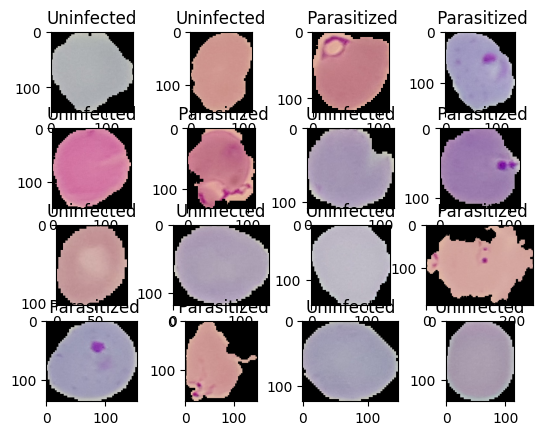

In [10]:
for i , sample in enumerate(train_ds.take(16)):
  ax = plt.subplot(4,4,i+1)
  print(sample['label'].numpy())
  plt.imshow(sample['image'])
  plt.title(get_label_str(sample['label'].numpy()))


Data Processing

In [11]:
train_ds

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [12]:
IM_SIZE = 224
BATCH_SIZE = 32

In [13]:
def resize_rescale(inputs):
  return tf.image.resize(inputs['image'], (IM_SIZE,IM_SIZE))/255.,inputs['label']

In [14]:
train_dataset = train_ds.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_ds.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_ds.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [29]:
for image, label in train_dataset.take(1):
  print(image,label)

tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
 

In [30]:
np.unique(image)

array([0.0000000e+00, 2.4972958e-05, 2.5500556e-05, ..., 9.2956269e-01,
       9.3221337e-01, 9.3645275e-01], dtype=float32)

In [31]:
model=tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters =6, kernel_size =3, strides=1 , padding='valid' , activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size =2, strides =2),
    Conv2D(filters =16, kernel_size =3, strides=1 , padding='valid' , activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size =2, strides =2),

    Flatten(),

    Dense(100, activation = "relu"),
    BatchNormalization(),
    Dense(10, activation = "relu"),
    BatchNormalization(),
    Dense(1, activation = "sigmoid"),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [32]:
y_true = [0,1,0,0]
y_pred = [0.2,0.9,0.1,0.]
bce = tf.keras.losses.BinaryCrossentropy()
print(bce(y_true, y_pred))


tf.Tensor(0.10846605, shape=(), dtype=float32)


In [37]:
model.compile(
    optimizer = Adam(learning_rate = 0.01),
    loss = BinaryCrossentropy(),
)

In [38]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    verbose=1
)

Epoch 1/10
 21/689 [..............................] - ETA: 14:00 - loss: 0.6713

KeyboardInterrupt: 

In [ ]:
model.evaluate(test_dataset)

In [39]:
def parasite_or_not(x):
  if x<0.5:
    return str("P")
  else:
    return str("U")

In [ ]:
print(parasite_or_not(model.predict(test_dataset.take(1))[0][0]))